<h1>Budowa algorytmu,przewidujacego ceny zamknięcia akcji(dowolnej do wyboru)<h1>


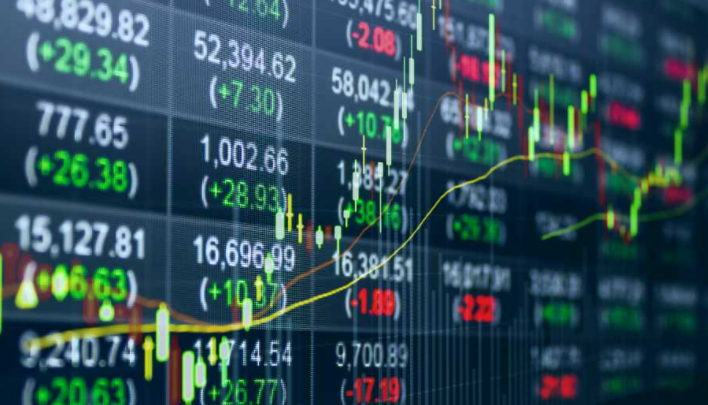


<blockquote>Celem przeprowadzenia niniejszych eksperymentów jest stworzenie algorytmu umożliwiającego generowanie predykcji kursów akcji zamknięcia kolejnego dnia działania
giełdy dla wybranej spólki.

<h2> Importowanie pakietów  oraz ich zalety<h2>

<blockquote>

Scikit-learn oraz Keras<br>
 <br>
• Wykorzystuje najpopularniejsze biblioteki związane z uczeniem maszynowym, takie jak NumPy, SciPy, Matplotlib, IPython, Sampy oraz Pandas.<br>
• Pozwala na łatwe i szybkie tworzenie modeli uczenia maszynowego za pomocą gotowych modułów ze zdefiniowanymi parametrami. 

Pandas<br>
    <br>
• Oferuje dostęp do narzędzi umożliwiających odczyt, zapis i konwersję danych w różnych formatach. <br>
• Automatyzuje procesy związane z uzupełnianiem brakujących danych i jest w stanie porządkować je według określonych reguł.<br> 
• Wspiera operacje na szeregach czasowych. <br>
• Pozwala na elastyczne przekształcanie i manipulowanie zawartościami struktur danych. <br>
• Potrafi operować na danych wielowymiarowych i skalować je do określonych potrzeb. <br>
<br>Numpy <br>
<br>• Posiada wydajne tablice służące do wykonywania dużej ilości złożonych operacji matematycznych i logicznych na zapisanych w nich obiektach.<br>
    <br>Yfinance<br>
    Sluzy do pobierania danych finansowych,bardzo przydatna biblioteka


In [184]:
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance
import time

import yfinance as yf

from pandas_datareader import data as pdr


# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

<h2>Czas na wybranie aktywów do naszego portfela. Ja teraz wezmę tylko 3 ale można ile się chce<h2>

In [216]:
asset1=["AMZN"]

In [230]:
asset2=["AAPL"]

<h2>Okreslenie horyzontu czasowego <h2>

In [217]:
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days= 365 * 5)
startDate

datetime.datetime(2017, 3, 8, 16, 39, 1, 917641)

<h2>Pobieranie danych z Yahoo Finance-zobaczcie jakie to proste <h2>

In [218]:
AMZN= pdr.get_data_yahoo(asset1, start=startDate, end=endDate)['Adj Close']

In [231]:
AAPL = pdr.get_data_yahoo(asset2, start=startDate, end=endDate)['Adj Close']

In [192]:
AAPL.tail()

Symbols,AAPL
Date,
2022-03-01,163.199997
2022-03-02,166.559998
2022-03-03,166.229996
2022-03-04,163.169998
2022-03-07,162.024994


In [219]:
AMZN.tail()

Symbols,AMZN
Date,
2022-03-01,3022.840088
2022-03-02,3041.050049
2022-03-03,2957.969971
2022-03-04,2912.820068
2022-03-07,2811.935059


<h2>Można stworzyć sobie wykres poglądowy aby zobaczyć jak prezentował się nasz szereg czasowy <h2>

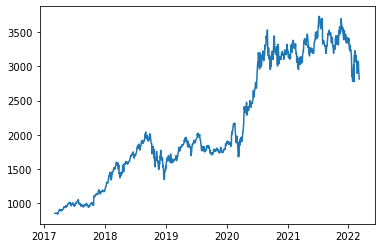

In [156]:
plt.plot(AMZN)

<h2>W Pythonie jest mozliwość obliczenia wielu miar, na przykład łatwo obliczyć stopę zwrotu <h2>

In [157]:
returns = (AMZN / AMZN.shift(1)) - 1
returns

Symbols,AMZN
Date,
2017-03-08,NaN
2017-03-09,0.002939
2017-03-10,-0.000633
2017-03-13,0.002499
2017-03-14,-0.002411
...,...
2022-03-01,-0.015765
2022-03-02,0.006024
2022-03-03,-0.027320


<h2>Wstępne przetworzenie danych<h2>

<blockquote>Zgromadzone dane zostały przekształcone
do formatu umożliwiającego trenowanie oraz testowanie wszystkich modeli
sztucznych sieci neuronowych z pamięcią skojarzeniową.

In [220]:
dataset=AMZN
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00252751],
       [0.0033931 ],
       [0.00320614],
       ...,
       [0.73220785],
       [0.71657536],
       [0.68164542]])

In [232]:
dataset1=AAPL
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0,1))
scaled_data1 = scaler.fit_transform(dataset1)
scaled_data1

array([[5.06794180e-04],
       [0.00000000e+00],
       [7.28441450e-04],
       ...,
       [8.95679383e-01],
       [8.75148601e-01],
       [8.68304973e-01]])

<h2>Aby nasz algorytm miał możliwość "nauczenia się" z poprzednich obserwacji,musimy go wytrenowac. <h2>

<blockquote>W tym celu dzielimy nasz zbiór danych w stosunku 80/20.<br>
Jest to typowy podział na dane treningowe na których zbiór będzie się uczył oraz testowe, które służyć będą do<br>
porównania wyników tej nauki z danymi rzeczywistymi.

<h3>Długosc calego zbioru danych <h3>

In [221]:
data_len = int(np.ceil( len(dataset)))
data_len 

1259

In [233]:
data_len1 = int(np.ceil( len(dataset1)))
data_len1

1259

<h3>Długość zbioru treningowego <h3>

In [222]:
training_data_len = int(np.ceil( len(dataset) * .8 ))
training_data_len

1008

In [234]:
training_data_len1 = int(np.ceil( len(dataset1) * .8 ))
training_data_len1

1008

In [223]:
train_data = scaled_data[0:int(training_data_len), :]
train_data

array([[0.00252751],
       [0.0033931 ],
       [0.00320614],
       ...,
       [0.74691938],
       [0.73012351],
       [0.76852104]])

In [235]:
train_data1 = scaled_data1[0:int(training_data_len1), :]
train_data1

array([[5.06794180e-04],
       [0.00000000e+00],
       [7.28441450e-04],
       ...,
       [5.90217349e-01],
       [5.56468302e-01],
       [5.88016285e-01]])

<h3>Teraz w ramach zbioru treningowego przystepujemy do trenowania sieci. Idealnie byłoby podzielić oryginalny zbiór danych na kolumnę wejściową (X) i wyjściową (y),<br>


<blockquote> A dlaczego? Ponieważ tu nastepuje proces trenowania modelu i przekazywania go do modelu testowego, x_train to dane ktore wchodza a y_train to dane ktore sa juz wytrrenowane i  one wychodza potem do modelu ,model sie teraz uczy.<br>
    <br>Algorytm próbuje przewidywac cene zamkniecia na podstawie 60 przeszłych obserwacji i jeśli nie zgadza się ona z z rzeczywista obserwacją, algorytm sie doskonali aż dochodzi do najlepszej swojej wydajnosci.

In [224]:
  
  # Split the data into x_train and y_train data sets
  x_train = []
  y_train = []

for i in range(60, len(train_data)):
      x_train.append(train_data[i-60:i, 0])
      y_train.append(train_data[i, 0])
      if i<=60:
         print(x_train)
         print(y_train)
         print()
          
  

[array([0.00252751, 0.0033931 , 0.00320614, 0.00394362, 0.00323038,
       0.0033827 , 0.00353851, 0.0031542 , 0.00476764, 0.        ,
       0.0016827 , 0.00144726, 0.00083442, 0.00125337, 0.00443181,
       0.01077484, 0.01147424, 0.01500582, 0.01672662, 0.02203095,
       0.02287923, 0.01907064, 0.01789343, 0.02210364, 0.02048327,
       0.01836084, 0.01435836, 0.02035516, 0.02097494, 0.01938917,
       0.0203794 , 0.0191572 , 0.02223175, 0.02230447, 0.02288267,
       0.02602996, 0.02831857, 0.03636507, 0.03591844, 0.0338722 ,
       0.03266037, 0.0314901 , 0.03664552, 0.0379543 , 0.03661437,
       0.03615388, 0.04090768, 0.0397374 , 0.04254192, 0.03516365,
       0.03991745, 0.04038488, 0.04413459, 0.04443582, 0.04748615,
       0.0519976 , 0.05282858, 0.05314711, 0.05242693, 0.05288743])]
[0.05661983509828977]



In [236]:
  # Split the data into x_train and y_train data sets
  x_train1 = []
  y_train1 = []

for i in range(60, len(train_data1)):
      x_train1.append(train_data1[i-60:i, 0])
      y_train1.append(train_data1[i, 0])
      if i<=60:
         print(x_train1)
         print(y_train1)
         print()
          

[array([0.00050679, 0.        , 0.00072844, 0.00082352, 0.00049103,
       0.00281896, 0.00318325, 0.00207465, 0.00440267, 0.00183704,
       0.00433924, 0.00354743, 0.00310393, 0.00348409, 0.00810845,
       0.0086153 , 0.00831438, 0.00788675, 0.00795012, 0.00964468,
       0.00845694, 0.00788675, 0.00737996, 0.00711076, 0.00467187,
       0.00494107, 0.00375331, 0.00498855, 0.0039909 , 0.00316738,
       0.00595466, 0.00568543, 0.00785507, 0.0092646 , 0.00791844,
       0.00809266, 0.00787099, 0.01251119, 0.01398397, 0.01327132,
       0.01243193, 0.01628032, 0.02269425, 0.02424629, 0.02309022,
       0.02518929, 0.02860832, 0.02797222, 0.02760645, 0.01930543,
       0.02294712, 0.02377397, 0.02525292, 0.02495078, 0.02421921,
       0.02506206, 0.02464861, 0.02474395, 0.02329692, 0.02396478])]
[0.027574609644860665]



In [225]:
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

  # Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


(948, 60, 1)

In [237]:
# Convert the x_train and y_train to numpy arrays 
x_train1, y_train1 = np.array(x_train1), np.array(y_train1)

  # Reshape the data
x_train1 = np.reshape(x_train1, (x_train1.shape[0], x_train1.shape[1], 1))
x_train1.shape

(948, 60, 1)

<h3>Najwazniejsza część-budowanie architektury LSTM <h3>

<blockquote>Celem eksperymentów jest wybranie najlepszej architektury dla sztucznych sieci
neuronowych z punktu widzenia omawianego zagadnienia. W niniejszych eksperymentach zastosowano metodę prób i błędów. <br>
 <br>Pod uwagę wzięłam szereg potencjalnie atrakcyjnych architektur z punktu widzenia efektywności generowania predykcji
notowań spółek.Wzorowałam się na często spotykanej architekturze spotykanej w różnych dziełach naukowych.Jednak poniżej zamieściłam też kilka wskazówek jak dobrac architekture idealną :)

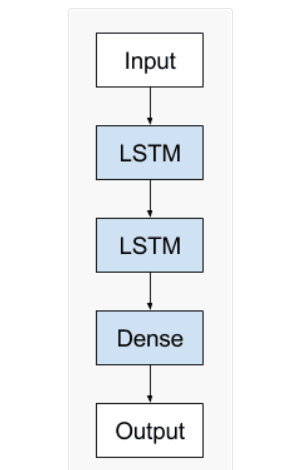

<blockquote>Siec neuronowa LSTM działa świetnie, ponieważ komórki LSTM mają pamięć, która może przechowywać informacje z poprzednich kroków czasowych i w ten sposób się uczyc nieustannie.<br>

<br>Wszystkie rekurencyjne sieci neuronowe mają postać łańcucha powtarzających się warstw sieci neuronowej.<br>
    
<br> Przed napisaniem tego kodu zbadałam szereg potencjalnie atrakcyjnych architektur z punktu widzenia efektywności generowania predykcji, a następnie  wyłoniłam najskuteczniejsze rozwiązanie. Okazała się nim struktura zawierająca dwie warstwy LSTM. Każda
z nich składa się ze 128 neuronów. Ponadto w architekturze zastosowano warstwę wyjściową Dense złożoną z jednego neuronu.<br>
<br>Ogólnie rzecz biorąc, 2 warstwy okazały się wystarczające do wykrywania bardziej złożonych cech. Więcej warstw może być  trudniejszych do wytrenowania. Ogólna zasada - 1 warstwa ukryta sprawdza się w przypadku bardzo prostych problemów, a dwie wystarczą do znalezienia w miarę złożonych problemów.Ja zastosowałam dwie warstwy.<br>
    

<h3>Jak dobrać odpowiednie parametry do naszej sieci? <h3>

https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

<blockquote>Nie ma ostatecznej, definitywnej zasady mówiącej, ile węzłów (lub ukrytych neuronów) lub ile warstw należy wybrać, i bardzo często podejście oparte na metodzie prób i błędów daje najlepsze wyniki dla danego problemu. 

Najczęściej stosowaną metodą jest prawdopodobnie walidacja krzyżowa k-krotna. Jednak nawet w przypadku procedury testowej musimy wybrać pewną liczbę (k) węzłów.
Punktem wyjścia może być poniższy wzór:

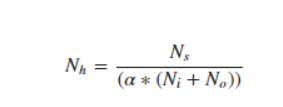


<blockquote>Nᵢ to liczba neuronów wejściowych, Nₒ to liczba neuronów wyjściowych, Nₛ to liczba próbek w danych treningowych, a α to współczynnik skalowania, który zwykle mieści się w przedziale od 2 do 10. <br>
<br>Możemy obliczyć 8 różnych liczb, które zostaną uwzględnione w procedurze walidacji, i znaleźć optymalny model na podstawie uzyskanej straty z walidacji.

In [226]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
    
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(1))

  # Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)


948/948 [==============================] - 20s 19ms/step - loss: 0.0029


In [238]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
    
# Build the LSTM model
model1 = Sequential()
model1.add(LSTM(128, return_sequences=True, input_shape= (x_train1.shape[1], 1)))
model1.add(LSTM(128, return_sequences=False))
model1.add(Dense(1))

  # Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
model1.fit(x_train1, y_train1, batch_size=1, epochs=1)


948/948 [==============================] - 20s 19ms/step - loss: 0.0014


In [227]:
test_data=scaled_data[training_data_len -60: , :]
x_test = []
y_test= dataset.iloc[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [239]:
test_data1=scaled_data1[training_data_len1 -60: , :]
x_test1 = []
y_test1= dataset1.iloc[training_data_len1:, :]
for i in range(60, len(test_data1)):
  x_test1.append(test_data1[i-60:i,0])



In [228]:
#Convert
x_test = np.array(x_test)
#reshape

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_test.shape

(251, 60, 1)

In [240]:
#Convert
x_test1 = np.array(x_test1)
#reshape

x_test1 = np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1))

x_test1.shape

(251, 60, 1)

<h2>Wyznaczenie przewidywanych wartości<h2>

In [229]:
predictions_AMZN=model.predict(x_test)
predictions_AMZN=scaler.inverse_transform(predictions_AMZN)
predictions_AMZN

array([[3158.995 ],
       [3159.3965],
       [3172.0916],
       [3185.8245],
       [3197.3237],
       [3207.4539],
       [3221.3486],
       [3220.359 ],
       [3218.83  ],
       [3221.6653],
       [3229.8203],
       [3232.6821],
       [3227.2114],
       [3219.1108],
       [3213.8262],
       [3207.7664],
       [3207.542 ],
       [3219.2546],
       [3244.2693],
       [3272.224 ],
       [3305.7705],
       [3340.2078],
       [3380.55  ],
       [3419.2095],
       [3454.8306],
       [3474.873 ],
       [3491.1868],
       [3505.937 ],
       [3514.17  ],
       [3513.1855],
       [3511.749 ],
       [3502.847 ],
       [3496.2078],
       [3500.8323],
       [3511.4668],
       [3529.6   ],
       [3550.7795],
       [3570.2031],
       [3575.0469],
       [3562.0981],
       [3536.533 ],
       [3513.0361],
       [3491.383 ],
       [3459.8323],
       [3432.6746],
       [3401.1145],
       [3373.2222],
       [3359.086 ],
       [3359.9512],
       [3362.9458],


In [241]:
predictions_AAPL=model1.predict(x_test1)
predictions_AAPL=scaler.inverse_transform(predictions_AAPL)
predictions_AAPL

array([[120.95268 ],
       [120.5758  ],
       [120.66561 ],
       [120.788414],
       [121.383385],
       [122.32202 ],
       [123.12467 ],
       [123.0727  ],
       [122.58841 ],
       [122.520805],
       [122.48418 ],
       [122.085754],
       [121.685005],
       [121.43841 ],
       [121.323845],
       [121.05076 ],
       [121.11883 ],
       [121.44684 ],
       [122.29516 ],
       [123.27071 ],
       [124.4158  ],
       [125.830505],
       [127.5378  ],
       [128.79967 ],
       [130.17897 ],
       [130.97513 ],
       [131.79291 ],
       [132.40735 ],
       [132.94136 ],
       [133.07083 ],
       [133.07605 ],
       [132.77272 ],
       [132.77306 ],
       [132.95186 ],
       [133.13058 ],
       [133.15944 ],
       [133.11156 ],
       [132.7198  ],
       [132.42897 ],
       [131.47702 ],
       [130.46626 ],
       [129.84659 ],
       [129.59825 ],
       [129.02116 ],
       [128.27362 ],
       [127.07894 ],
       [126.24998 ],
       [126.0

In [242]:
#Visualize the data

train=AMZN[:training_data_len]
valid=AMZN[training_data_len:]


In [248]:
train1=AAPL[:training_data_len1]
valid1=AAPL[training_data_len1:]

In [244]:
valid['Predictions']=predictions_AMZN

C:\Users\weron\AppData\Local\Temp/ipykernel_20556/412511370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions']=predictions_AMZN


In [245]:
valid

Symbols,AMZN,Predictions
Date,,
2021-03-10,3057.639893,3158.995117
2021-03-11,3113.590088,3159.396484
2021-03-12,3089.489990,3172.091553
2021-03-15,3081.679932,3185.824463
2021-03-16,3091.860107,3197.323730
...,...,...
2022-03-01,3022.840088,3164.139160
2022-03-02,3041.050049,3164.024170
2022-03-03,2957.969971,3165.595703


In [249]:
valid1['Predictions']=predictions_AAPL
valid1

C:\Users\weron\AppData\Local\Temp/ipykernel_20556/945249302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid1['Predictions']=predictions_AAPL


Symbols,AAPL,Predictions
Date,,
2021-03-10,119.271118,120.952682
2021-03-11,121.239410,120.575798
2021-03-12,120.314903,120.665611
2021-03-15,123.257416,120.788414
2021-03-16,124.828079,121.383385
...,...,...
2022-03-01,163.199997,162.037827
2022-03-02,166.559998,161.797348
2022-03-03,166.229996,162.129501


<h3>Mozemy zobaczyc tez wykresy<h3>

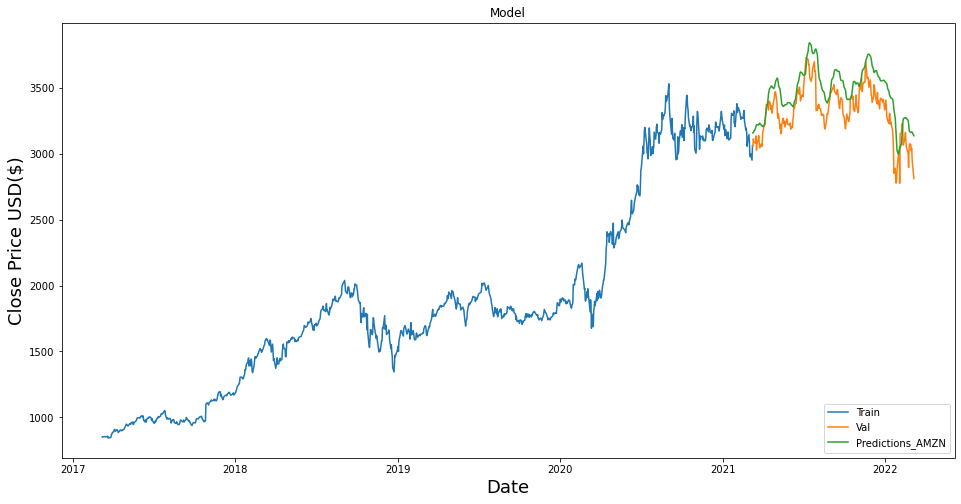

In [269]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['AMZN'])
plt.plot(valid[['AMZN', 'Predictions']])
plt.legend(['Train','Val','Predictions_AMZN'], loc= 'lower right')


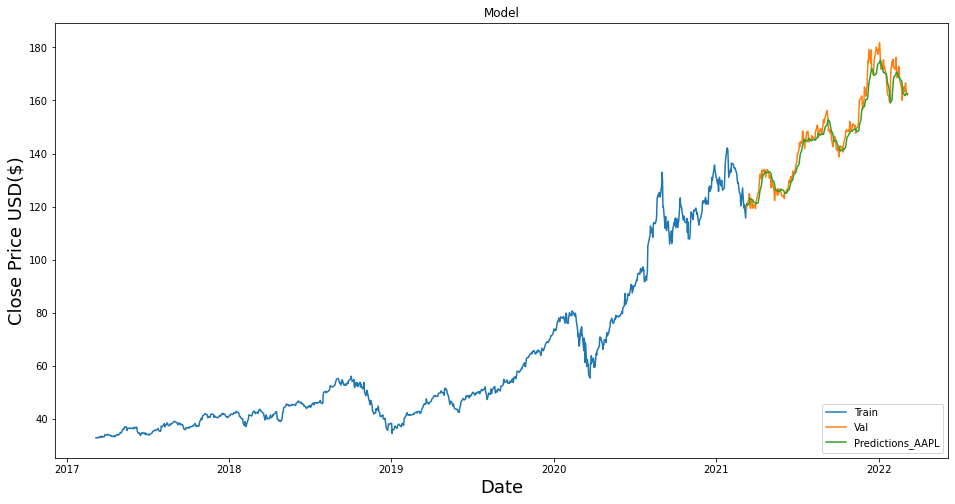

In [272]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train1['AAPL'])
plt.plot(valid1[['AAPL', 'Predictions']])
plt.legend(['Train','Val','Predictions_AAPL'], loc= 'lower right')


<<h3>Widzimy, że algorytm znacznie lepiej dopasował wartości APPLE <h3>

In [250]:
final=valid.merge(valid1, on='Date', how='left')
final


Symbols,AMZN,Predictions_x,AAPL,Predictions_y
Date,,,,
2021-03-10,3057.639893,3158.995117,119.271118,120.952682
2021-03-11,3113.590088,3159.396484,121.239410,120.575798
2021-03-12,3089.489990,3172.091553,120.314903,120.665611
2021-03-15,3081.679932,3185.824463,123.257416,120.788414
2021-03-16,3091.860107,3197.323730,124.828079,121.383385
...,...,...,...,...
2022-03-01,3022.840088,3164.139160,163.199997,162.037827
2022-03-02,3041.050049,3164.024170,166.559998,161.797348
2022-03-03,2957.969971,3165.595703,166.229996,162.129501


In [251]:
final=(final.set_axis(['AMZN','P_AMZN','AAPL', 'P_AAPL'], axis=1))
final

,AMZN,P_AMZN,AAPL,P_AAPL
Date,,,,
2021-03-10,3057.639893,3158.995117,119.271118,120.952682
2021-03-11,3113.590088,3159.396484,121.239410,120.575798
2021-03-12,3089.489990,3172.091553,120.314903,120.665611
2021-03-15,3081.679932,3185.824463,123.257416,120.788414
2021-03-16,3091.860107,3197.323730,124.828079,121.383385
...,...,...,...,...
2022-03-01,3022.840088,3164.139160,163.199997,162.037827
2022-03-02,3041.050049,3164.024170,166.559998,161.797348
2022-03-03,2957.969971,3165.595703,166.229996,162.129501


In [256]:
predictions= final[["P_AMZN", "P_AAPL"]]
predictions

,P_AMZN,P_AAPL
Date,,
2021-03-10,3158.995117,120.952682
2021-03-11,3159.396484,120.575798
2021-03-12,3172.091553,120.665611
2021-03-15,3185.824463,120.788414
2021-03-16,3197.323730,121.383385
...,...,...
2022-03-01,3164.139160,162.037827
2022-03-02,3164.024170,161.797348
2022-03-03,3165.595703,162.129501


<h3>Mamy portfel,mozemy na podstawie przewidzianych wartosci obliczyc czy portfel jest fajny i w co zainwestowac a co raczej wyrzucic <h3>

In [257]:
#korelacja
predictions.corr()

,P_AMZN,P_AAPL
P_AMZN,1.000000,0.059161
P_AAPL,0.059161,1.000000


In [480]:
pip install PyPortfolioOpt

Note: you may need to restart the kernel to use updated packages.Collecting cvxpy<2.0.0,>=1.1.10



<h3>Modern portfolio theory in Python=>https://s3.amazonaws.com/assets.datacamp.com/production/course_18408/slides/chapter4.pdf<h3>

<h6>(EFFICIENT FRONTIER)Granica efektywności to zbiór optymalnych portfeli, które oferują najwyższy oczekiwany zwrot przy określonym poziomie ryzyka lub najniższe ryzyko przy danym poziomie oczekiwanego zwrotu. Portfele znajdujące się poniżej granicy efektywności są nieoptymalne, ponieważ nie zapewniają wystarczającej stopy zwrotu przy danym poziomie ryzyka.<h6>

In [262]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage


mu = mean_historical_return(predictions)
S = CovarianceShrinkage(predictions).ledoit_wolf()

In [263]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'P_AMZN': 0.0, 'P_AAPL': 1.0}


<h6>Wyznaczylismy wagi dwoch skladnikow portfela, oczywiscie gdy by portfel skaladal sie  3 lub wiecej aktywow, wagi roznilyby sie <h6>

<h3>Jakiej stopy zwrotu mozemy oczekiwać? <h3>

In [264]:
ef.portfolio_performance(verbose=True)

Expected annual return: 34.7%
Annual volatility: 8.3%
Sharpe Ratio: 3.94


(0.34662442250662484, 0.08283166744777855, 3.9432312854566893)

<h5>WSKAŹNIK SHARPA INTERPRETACJA:Wskaźnik Sharpe'a w przedziale 0 – 0,99 informuje nas że portfel czy inwestor zarabia, ale nie jest efektywny, ponieważ ponosi dużo większe ryzyko niż wypracowuje zwrotu. Wskaźnik ujemny oczywiście świadczy o stracie. Współczynnik powyżej 1 już informuje nas że zwrot przekracza poniesione ryzyko.<h5>

<h3>Ile czego kupić jesli mam 100tys? <h3>

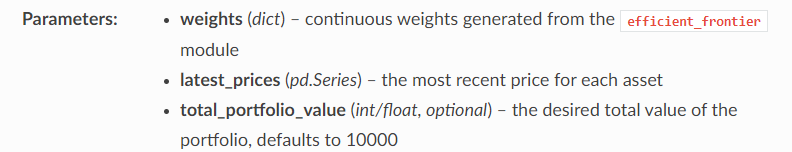

In [265]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(predictions)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'P_AAPL': 615}
Funds remaining: $66.44


<h2>PODSUMOWANIE<h2>

Jeśli miałabym ufać powyzszemu algorytmowi(który oczywiście nie ejst idealny i wymaga jescze dopracowania) -algorytm ten doradza mi kupic<br>
<br>615 akcji APPLE i 0 akcji AMZN.
                                          